## CYAN Cyanobacteria Concentration

In [50]:
# Check directory
import os
os.getcwd()

'/home/jovyan/work/FinalProject'

### Plot one pair of file

In [ ]:
#pip install --upgrade matplotlib

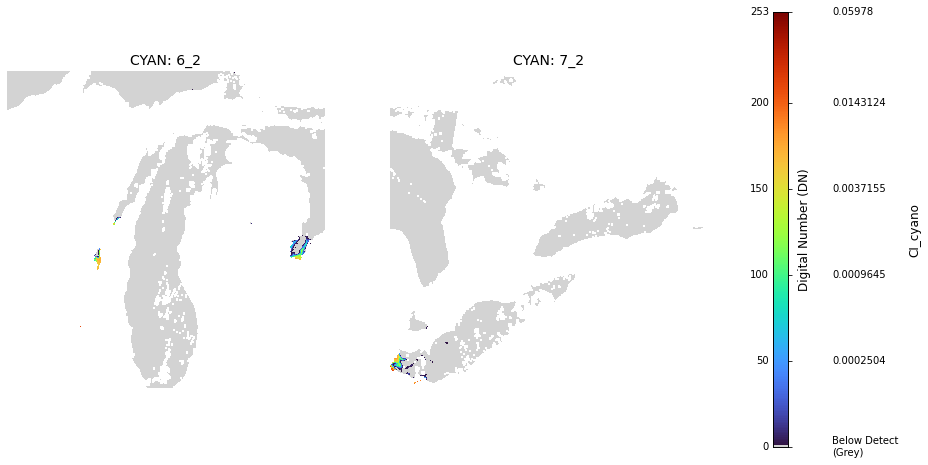

In [49]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

# Define paths to your .tif files
file_path1 = 'CYAN_Weekly_2009_2024/L20162272016233.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_6_2.tif'
file_path2 = 'CYAN_Weekly_2009_2024/L20162272016233.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_7_2.tif'

# Open the first .tif file
with rasterio.open(file_path1) as src1:
    image1 = src1.read(1)  # Read the first band

# Open the second .tif file
with rasterio.open(file_path2) as src2:
    image2 = src2.read(1)  # Read the first band

# Mask invalid values (DN=254 for land, DN=255 for no data)
image1 = np.ma.masked_where(image1 >= 254, image1)  # Mask land and no-data pixels
image2 = np.ma.masked_where(image2 >= 254, image2)

# Customize the colormap: Use turbo and modify for DN=0
original_cmap = plt.cm.turbo  # Load the turbo colormap
colors = original_cmap(np.linspace(0, 1, 256))  # Get 256 colors from the colormap
colors[0] = [0.83, 0.83, 0.83, 1.0]  # Light grey for DN=0 (RGB: 211, 211, 211)
custom_cmap = ListedColormap(colors)

# Create a figure with GridSpec for precise layout control
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # Add space for vertical color bar

# Add the first plot
ax1 = fig.add_subplot(gs[0, 0])  # Left plot
im1 = ax1.imshow(image1, cmap=custom_cmap, vmin=0, vmax=253)  # Use the custom colormap
ax1.set_title('CYAN: 6_2', fontsize=14)
ax1.axis('off')  # Turn off axes for cleaner display

# Add the second plot
ax2 = fig.add_subplot(gs[0, 1])  # Right plot
im2 = ax2.imshow(image2, cmap=custom_cmap, vmin=0, vmax=253)  # Use the custom colormap
ax2.set_title('CYAN: 7_2', fontsize=14)
ax2.axis('off')  # Turn off axes for cleaner display

# Add a shared vertical color bar to the right
cbar_ax = fig.add_subplot(gs[0, 2])  # Right-most column
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')

# Add ticks for DN values
cbar.set_ticks([0, 50, 100, 150, 200, 253])
cbar.ax.set_yticklabels([
    '0', '50', '100', '150', '200', '253'  # DN values
], fontsize=10, va='center')

# Add CI_Cyano labels on the right side of the color bar
cbar.ax.tick_params(axis='y', which='both', length=0)  # Remove default tick marks
cbar.ax2 = cbar_ax.twinx()  # Add a second axis on the right
cbar.ax2.set_yticks([0, 50, 100, 150, 200, 253])  # Match DN ticks
cbar.ax2.set_yticklabels([
    'Below Detect\n(Grey)', 
    '0.0002504', 
    '0.0009645', 
    '0.0037155', 
    '0.0143124', 
    '0.05978'
], fontsize=10, va='center')
cbar.ax2.tick_params(axis='y', which='both', pad=40)


# Add labels for the sides
cbar.ax.set_ylabel('Digital Number (DN)', fontsize=12, labelpad=10)  # Left side label
cbar.ax2.set_ylabel('CI_cyano', fontsize=12, labelpad=10)  # Right side label

# Adjust layout to tighten spacing
plt.subplots_adjust(wspace=0.3)  # Increase space between plots and color bar

plt.show()

### Merge 6_2 and 7_2 for each week

In [ ]:
import os
from glob import glob
import rasterio
from rasterio.merge import merge

# Define input and output directories
input_dir = "CYAN_Weekly_2009_2024"
output_dir = "Merged_CYAN_Weekly"
os.makedirs(output_dir, exist_ok=True)

# Get a sorted list of all `.tif` files
all_files = sorted(glob(os.path.join(input_dir, "*.tif")))

# Debugging: Print total number of files found
print(f"Found {len(all_files)} .tif files in {input_dir}")

# Group files by week identifier (e.g., `L20161152016121`)
file_groups = {}
for file in all_files:
    # Extract the week identifier (everything before "_6_2" or "_7_2")
    week_id = "_".join(file.split("_")[:-2])
    if week_id not in file_groups:
        file_groups[week_id] = []
    file_groups[week_id].append(file)

# Debugging: Print grouped file information
print(f"Identified {len(file_groups)} unique weeks")

# Process each group
for week_id, files in file_groups.items():
    # Ensure each group has exactly one `6_2` and one `7_2` file
    files_6_2 = [f for f in files if "6_2" in f]
    files_7_2 = [f for f in files if "7_2" in f]
    
    if len(files_6_2) == 1 and len(files_7_2) == 1:
        # Open the datasets for the current week
        try:
            datasets = [rasterio.open(files_6_2[0]), rasterio.open(files_7_2[0])]

            # Merge the datasets
            merged_array, merged_transform = merge(datasets)

            # Define the output file name
            output_file_name = f"{week_id}_merged.tif"
            output_file_path = os.path.join(output_dir, output_file_name)

            # Ensure the parent directory of the output file exists
            os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

            # Debugging: Check output file path
            print(f"Merging files for week {week_id}:")
            print(f"  - {files_6_2[0]}")
            print(f"  - {files_7_2[0]}")
            print(f"Saving merged file to: {output_file_path}")

            # Save the merged raster
            with rasterio.open(
                output_file_path,
                "w",
                driver="GTiff",
                height=merged_array.shape[1],
                width=merged_array.shape[2],
                count=1,  # Assuming single-band rasters
                dtype=merged_array.dtype,
                crs=datasets[0].crs,
                transform=merged_transform,
            ) as dst:
                dst.write(merged_array[0], 1)  # Write the first band of the merged array

            print(f"Merged file saved: {output_file_path}")

        except Exception as e:
            print(f"Error processing week {week_id}: {e}")

        finally:
            # Ensure datasets are closed
            for dataset in datasets:
                dataset.close()

    else:
        print(f"Skipping week {week_id}: Missing or duplicate files")

#### Check one merged map

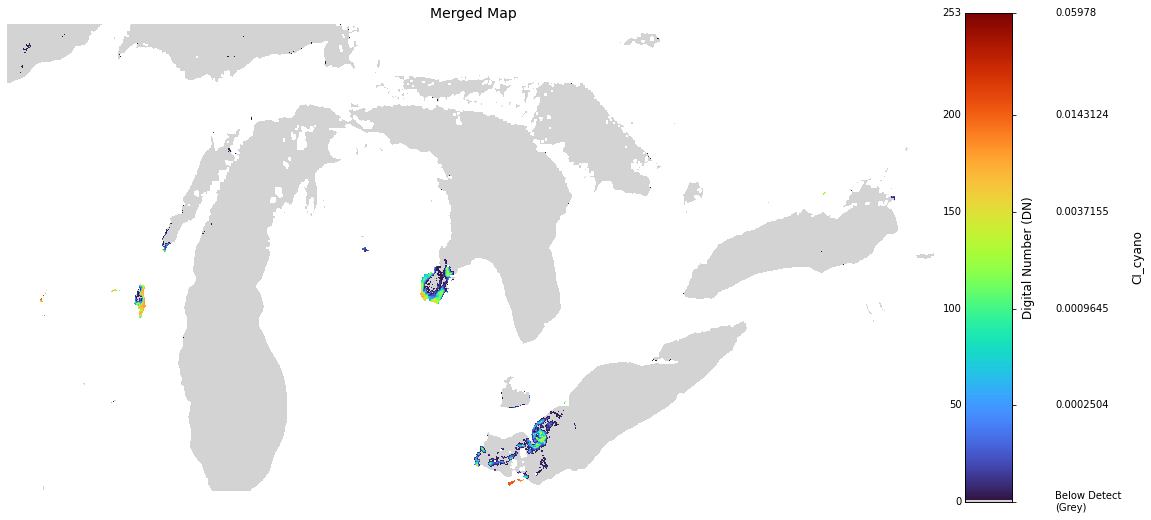

In [104]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

# Path to the merged `.tif` file
file_path = 'Merged_CYAN_Weekly/CYAN_Weekly_2009_2024/L20162622016268.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_merged.tif'

# Open the merged file
with rasterio.open(file_path) as src:
    image = src.read(1)  # Read the first band

# Mask invalid values (DN=254 for land, DN=255 for no data)
image = np.ma.masked_where(image >= 254, image)  # Mask invalid values (e.g., no data)

# Customize the colormap: Use turbo and modify for DN=0
original_cmap = plt.cm.turbo  # Load the turbo colormap
colors = original_cmap(np.linspace(0, 1, 256))  # Get 256 colors from the colormap
colors[0] = [0.83, 0.83, 0.83, 1.0]  # Light grey for DN=0 (RGB: 211, 211, 211)
custom_cmap = ListedColormap(colors)

# Create a figure with GridSpec for precise layout control
fig = plt.figure(figsize=(18, 9))
gs = GridSpec(1, 2, width_ratios=[1, 0.05])  # Add space for vertical color bar

# Add the plot for the merged raster
ax = fig.add_subplot(gs[0, 0])  # Main plot area
im = ax.imshow(image, cmap=custom_cmap, vmin=0, vmax=253)  # Use custom colormap
ax.set_title('Merged Map', fontsize=14)
ax.axis('off')  # Turn off axes for cleaner display

# Add the color bar on the right
cbar_ax = fig.add_subplot(gs[0, 1])  # Space for the color bar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')

# Add ticks for DN values
cbar.set_ticks([0, 50, 100, 150, 200, 253])  # Digital number ticks
cbar.ax.set_yticklabels([
    '0', '50', '100', '150', '200', '253'  # Digital number labels
], fontsize=10, va='center')

# Add labels for the right side of the color bar
cbar.ax.tick_params(axis='y', which='both', length=0)  # Remove default tick marks
cbar.ax2 = cbar_ax.twinx()  # Add a secondary y-axis on the right for CI_cyano values
cbar.ax2.set_yticks([0, 50, 100, 150, 200, 253])  # Match DN ticks
cbar.ax2.set_yticklabels([
    'Below Detect\n(Grey)', 
    '0.0002504', 
    '0.0009645', 
    '0.0037155', 
    '0.0143124', 
    '0.05978'
], fontsize=10, va='center')
cbar.ax2.tick_params(axis='y', which='both', pad=40)

# Add side labels for the color bar
cbar.ax.set_ylabel('Digital Number (DN)', fontsize=12, labelpad=10)  # Left side label
cbar.ax2.set_ylabel('CI_cyano', fontsize=12, labelpad=10)  # Right side label

# Adjust layout to tighten spacing
plt.subplots_adjust(wspace=0.05)  # Adjust spacing between the plot and color bar

plt.show()

### Create CYAN metadata

In [60]:
import os
import pandas as pd
from datetime import datetime

# Define the directory containing the files
base_dir = "Merged_CYAN_Weekly/CYAN_Weekly_2009_2024"
files = [f for f in os.listdir(base_dir) if f.endswith('.tif')]

metadata = []
for file in files:
    # Split the filename to extract parts
    # Example: L20161152016121.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_6_2.tif
    parts = file.split('.')
    main_part = parts[0]  # "L20161152016121"
    #region = parts[-2].split('_')[-2] + "_" + parts[-2].split('_')[-1]  # Extract "6_2" or "7_2"
    
    # Extract start and end dates (YYYYDDD format)
    start_year = int(main_part[1:5])  # Extract year: "2016"
    start_julian_day = int(main_part[5:8])  # Extract Julian day: "115"
    end_year = int(main_part[8:12])  # Extract year: "2016"
    end_julian_day = int(main_part[12:15])  # Extract Julian day: "121"
    
    # Convert Julian days to standard dates
    start_date = datetime.strptime(f"{start_year}{start_julian_day:03d}", "%Y%j")
    end_date = datetime.strptime(f"{end_year}{end_julian_day:03d}", "%Y%j")
    
    # Append the metadata for this file
    metadata.append({
        'filename': file,
        'start_date': start_date,
        'end_date': end_date
    })

# Create a DataFrame to store the metadata
df = pd.DataFrame(metadata)

# Save the metadata to a CSV file
df.to_csv("cyan_metadata.csv", index=False)

In [62]:
# Verify Metadata
import pandas as pd

# Load the metadata
metadata = pd.read_csv("cyan_metadata.csv")

# Check for missing values
print(metadata.isnull().sum())

# Verify if all files in metadata exist in the directory
import os
data_dir = "Merged_CYAN_Weekly/CYAN_Weekly_2009_2024"
all_files = set(os.listdir(data_dir))
metadata_files = set(metadata['filename'])

missing_files = metadata_files - all_files
print(f"Missing files: {missing_files}")

end_date      0
filename      0
start_date    0
dtype: int64
Missing files: set()


### Clip CYAN data to Lake Erie boundary

In [85]:
# Lake boundary
import geopandas as gpd

# Path to your shapefile
shapefile_path = "Lakes_Boundary"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Search for "Lake Erie" across all columns
for col in gdf.columns:
    # Skip non-string columns
    if gdf[col].dtype == 'object' or gdf[col].dtype.name == 'category':
        # Ensure column is not geometry and check for "Lake Erie"
        if gdf[col].dropna().str.contains("Lake Erie", case=False).any():
            print(f"Found 'Lake Erie' in column: {col}")

for col in gdf.columns:
    # Skip non-string columns
    if gdf[col].dtype == 'object' or gdf[col].dtype.name == 'category':
        # Ensure column is not geometry and check for "Lake Erie"
        if gdf[col].dropna().str.contains("Lake Huron", case=False).any():
            print(f"Found 'Lake Huron' in column: {col}")

Found 'Lake Erie' in column: name
Found 'Lake Erie' in column: label
Found 'Lake Huron' in column: name
Found 'Lake Huron' in column: label


In [69]:
with rasterio.open(merged_files[0]) as src:
    raster_crs = src.crs
raster_crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

In [87]:
# Check the bounding box of the raster
with rasterio.open(merged_files[0]) as src:
    raster_bounds = src.bounds
    print(f"Raster Bounds: {raster_bounds}")

# Check the bounding box of Lake Erie
lake_bounds = lake_erie.total_bounds  # xmin, ymin, xmax, ymax
print(f"Lake Erie Bounds: {lake_bounds}")

# Verify overlap
from shapely.geometry import box

raster_box = box(*raster_bounds)
lake_box = box(*lake_bounds)

if not raster_box.intersects(lake_box):
    raise ValueError("Lake Erie geometry does not overlap with the raster.")

Raster Bounds: BoundingBox(left=434402.9533101199, bottom=2114826.2670775685, right=1634402.95331012, top=2714826.2670775685)
Lake Erie Bounds: [1031854.73739668 2121876.39607314 1385529.33948626 2356395.29398589]


In [ ]:
import os
from glob import glob
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

# Define paths
lake_shapefile = "Lakes_Boundary/ne_10m_lakes.shp"
merged_dir = "Merged_CYAN_Weekly/CYAN_Weekly_2009_2024"
output_dir = "Clipped2_Lake_Erie"
os.makedirs(output_dir, exist_ok=True)

# Load the Lake Erie boundary from the shapefile
lakes = gpd.read_file(lake_shapefile)

# Get the CRS of the first raster file
with rasterio.open(glob(os.path.join(merged_dir, "*.tif"))[0]) as src:
    raster_crs = src.crs

# Reproject Lake Erie shapefile to match raster CRS
lakes = lakes.to_crs(raster_crs)
lake_erie = lakes[lakes['name'] == 'Lake Erie']

if lake_erie.empty:
    raise ValueError("Lake Erie not found in the shapefile. Check the 'name' attribute.")

# Process all merged `.tif` files
merged_files = sorted(glob(os.path.join(merged_dir, "*.tif")))
print(f"Found {len(merged_files)} merged files to clip.")

for file in merged_files:
    with rasterio.open(file) as src:
        raster_bounds = src.bounds
        lake_bounds = lake_erie.total_bounds

        # Check if the raster and Lake Erie overlap
        raster_box = box(*raster_bounds)
        lake_box = box(*lake_bounds)

        if not raster_box.intersects(lake_box):
            print(f"File {file} does not overlap with Lake Erie. Skipping...")
            continue

        # Clip the raster using the Lake Erie geometry
        try:
            clipped_image, clipped_transform = mask(
                src, 
                lake_erie.geometry, 
                crop=True
            )

            # Update metadata for the clipped raster
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                "height": clipped_image.shape[1],
                "width": clipped_image.shape[2],
                "transform": clipped_transform
            })

            # Define output file path
            output_file = os.path.join(output_dir, os.path.basename(file))

            # Save the clipped raster
            with rasterio.open(output_file, "w", **clipped_meta) as dst:
                dst.write(clipped_image)

            print(f"Clipped file saved: {output_file}")

        except Exception as e:
            print(f"Error clipping file {file}: {e}")

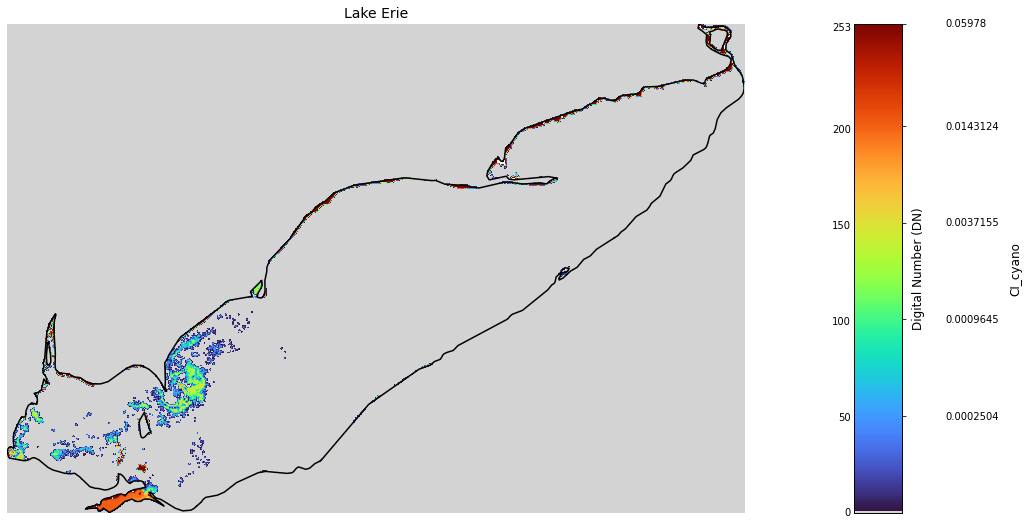

In [113]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Path to the merged `.tif` file
file_path = 'Clipped2_Lake_Erie/L20162622016268.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_merged.tif'

# Path to the Lake Erie shapefile
lake_shapefile = "Lakes_Boundary/ne_10m_lakes.shp"

# Open the merged file
with rasterio.open(file_path) as src:
    image = src.read(1)  # Read the first band
    extent = src.bounds  # Get raster bounds for plotting
    transform = src.transform  # Get transformation for aligning shapefile

# Load the Lake Erie boundary shapefile
lakes = gpd.read_file(lake_shapefile)

# Reproject Lake Erie to match the CRS of the raster
lake_erie = lakes[lakes['name'] == 'Lake Erie']
lake_erie = lake_erie.to_crs(crs=src.crs)

# Customize the colormap: DN=0 is light grey, DN=255 is white
original_cmap = plt.cm.turbo
colors = original_cmap(np.linspace(0, 1, 256))
colors[0] = [0.83, 0.83, 0.83, 1.0]  # Light grey for DN=0 (RGB: 211, 211, 211)
colors[255] = [1.0, 1.0, 1.0, 1.0]   # White for DN=255 (RGB: 255, 255, 255)
custom_cmap = ListedColormap(colors)

# Create a figure with GridSpec for precise layout control
fig = plt.figure(figsize=(18, 9))
gs = GridSpec(1, 2, width_ratios=[1, 0.05])  # Add space for vertical color bar

# Add the plot for the merged raster
ax = fig.add_subplot(gs[0, 0])  # Main plot area
im = ax.imshow(image, cmap=custom_cmap, extent=[extent.left, extent.right, extent.bottom, extent.top])
ax.set_title('Lake Erie', fontsize=14)
ax.axis('off')  # Turn off axes for cleaner display

# Overlay Lake Erie boundary
lake_erie.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, label='Lake Boundary')

# Add the color bar on the right
cbar_ax = fig.add_subplot(gs[0, 1])  # Space for the color bar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')

# Add ticks for DN values
cbar.set_ticks([0, 50, 100, 150, 200, 253])  # Digital number ticks
cbar.ax.set_yticklabels([
    '0', '50', '100', '150', '200', '253'  # Digital number labels
], fontsize=10, va='center')

# Add labels for the right side of the color bar
cbar.ax.tick_params(axis='y', which='both', length=0)  # Remove default tick marks
cbar.ax2 = cbar_ax.twinx()  # Add a secondary y-axis on the right for CI_cyano values
cbar.ax2.set_yticks([50, 100, 150, 200, 253])  # Match DN ticks
cbar.ax2.set_yticklabels([
    '0.0002504', 
    '0.0009645', 
    '0.0037155', 
    '0.0143124', 
    '0.05978',
], fontsize=10, va='center')
cbar.ax2.tick_params(axis='y', which='both', pad=40)

# Add side labels for the color bar
cbar.ax.set_ylabel('Digital Number (DN)', fontsize=12, labelpad=10)  # Left side label
cbar.ax2.set_ylabel('CI_cyano', fontsize=12, labelpad=10)  # Right side label

# Adjust layout to tighten spacing
plt.subplots_adjust(wspace=0.001)  # Adjust spacing between the plot and color bar

plt.show()

I was hoping we can make DN=255 (no data) to be white or DN=254 (land) to be another color, but I only got everything in grey.

## AQUA MODIS Chlorophyll Concentration (didn't work)

In [51]:
# Check downloading status
file_path = "AQUA_MODIS.20090109_20090116.L3b.8D.CHL.nc"

# Check file size
file_size = os.path.getsize(file_path)
print(f"File size: {file_size} bytes")

File size: 159118918 bytes


In [23]:
from netCDF4 import Dataset

# Open the file
file_path = "Broken_CHL_8day/AQUA_MODIS.20230922_20230929.L3b.8D.CHL.x.nc"
nc = Dataset(file_path, mode='r')
print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    product_name: AQUA_MODIS.20230922_20230929.L3b.8D.CHL.x.nc
    title: MODIS Level-3 Binned Data
    instrument: MODIS
    platform: Aqua
    temporal_range: 8-day
    start_orbit_number: 113747
    end_orbit_number: 113865
    date_created: 2024312043648000
    processing_version: unspecified
    source: satellite observations from MODIS-Aqua
    history: /sdps/sdpsoper/Science/OCSSW/DEVEL/bin/l3bin ifile=AQUA_MODIS.20230922_20230929.L3b.8D.CHL.nc ofile=AQUA_MODIS.20230922_20230929.L3b.8D.CHL.x.nc latnorth=46.0000 latsouth=41.0000 lonwest=-84.0000 loneast=-78.0000
    time_coverage_start: 2023-09-22T00:00:00.000Z
    time_coverage_end: 2023-09-30T02:45:00.000Z
    northernmost_latitude: 45.979168
    southernmost_latitude: 41.395832
    easternmost_longitude: -77.944374
    westernmost_longitude: -83.998
    geospatial_lat_max: 45.97916793823242
    geospatial_lat_min: 41.39583206176758
    geospa

In [29]:
# Access the 'level-3_binned_data' group
bin_group = nc.groups['level-3_binned_data']

# List the variables in the group
print("Variables in level-3_binned_data group:", bin_group.variables.keys())

Variables in level-3_binned_data group: odict_keys(['BinList', 'chlor_a', 'BinIndex'])


In [30]:
# Access the variables
bin_list = bin_group.variables['BinList'][:]
chlor_a = bin_group.variables['chlor_a'][:]
bin_index = bin_group.variables['BinIndex'][:]

# Print shapes or summaries
print("BinList shape:", bin_list.shape)
print("Chlorophyll data shape:", chlor_a.shape)
print("BinIndex shape:", bin_index.shape)

BinList shape: (4115,)
Chlorophyll data shape: (4115,)
BinIndex shape: (4320,)


In [33]:
print(type(bin_list))        # Check the type of bin_list
print(bin_list.dtype)        # Check the data type of elements in bin_list
print(bin_list[:10])         # Print the first 10 elements for inspection

<class 'numpy.ndarray'>
{'names':['bin_num','nobs','nscenes','weights','time_rec'], 'formats':['<u4','<i2','<i2','<f4','<f4'], 'offsets':[0,4,6,8,12], 'itemsize':16, 'aligned':True}
[(19735650,  3, 1, 1.7320508, 2.9086853e+09)
 (19742128, 10, 2, 4.       , 9.6957071e+09)
 (19742129, 23, 3, 7.4494896, 2.2301059e+10)
 (19742130, 28, 3, 8.537319 , 2.7149740e+10)
 (19742131, 17, 2, 5.473708 , 1.6482818e+10)
 (19742132,  8, 2, 3.9681187, 7.7567611e+09)
 (19742133,  5, 2, 3.1462643, 4.8479867e+09)
 (19748603,  6, 1, 2.4494898, 5.8173706e+09)
 (19748604, 31, 2, 7.8481917, 3.0057570e+10)
 (19748605, 36, 3, 9.7787285, 3.4907107e+10)]


In [40]:
print("Type of chlor_a:", type(chlor_a))
print("Dtype of chlor_a:", chlor_a.dtype)
print("Shape of chlor_a:", chlor_a.shape)
print("First few chlor_a values:", chlor_a[:5])

Type of chlor_a: <class 'numpy.ndarray'>
Dtype of chlor_a: {'names':['sum','sum_squared'], 'formats':['<f4','<f4'], 'offsets':[0,4], 'itemsize':8, 'aligned':True}
Shape of chlor_a: (4115,)
First few chlor_a values: [( 97.989914, 5557.3955) (110.66994 , 3204.6494) (210.26839 , 7608.828 )
 (224.31038 , 7728.811 ) (128.12979 , 3135.702 )]


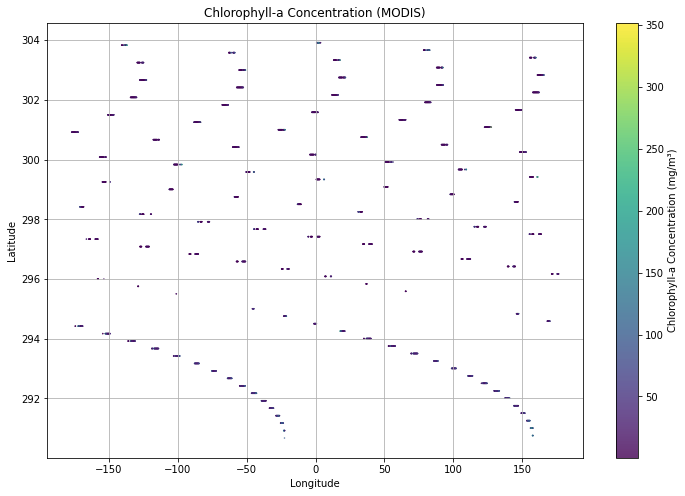

In [44]:
# Plot Chlorophyll a concentration (didn't work)
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Open the NetCDF file
file_path = "MODIS_CHL_8day/AQUA_MODIS.20230922_20230929.L3b.8D.CHL.x.nc"
nc = Dataset(file_path, mode='r')

# Access the 'level-3_binned_data' group
bin_group = nc.groups['level-3_binned_data']

# Access the variables
bin_list = bin_group.variables['BinList'][:]
chlor_a = bin_group.variables['chlor_a'][:]

# Extract bin numbers from BinList
bin_nums = bin_list['bin_num']

# Extract the `sum` field for chlorophyll-a values
chlor_a_sum = chlor_a['sum']

# Mask invalid chlorophyll-a values (e.g., <= 0)
chlor_a_masked = np.ma.masked_where(chlor_a_sum <= 0, chlor_a_sum)

# Calculate latitudes and longitudes from bin numbers
latitudes = (bin_nums // 4320) * 0.0833333 - 90  # Replace 4320 with bins-per-row based on resolution
longitudes = (bin_nums % 4320) * 0.0833333 - 180

# Create a scatter plot of chlorophyll-a data
plt.figure(figsize=(12, 8))
sc = plt.scatter(longitudes, latitudes, c=chlor_a_masked, cmap='viridis', s=1, marker='.', alpha=0.8)
plt.colorbar(sc, label='Chlorophyll-a Concentration (mg/m³)')
plt.title('Chlorophyll-a Concentration (MODIS)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()